In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [2]:
# Load dataset
df = pd.read_csv("../data/newData.csv")  # replace with your file path

# Keep only needed columns
df = df[['text', 'label_num']]  # text = email, label_num = 0(ham)/1(spam)

print(df.head())
print(df['label_num'].value_counts())  # check spam/ham distribution


                                                text  label_num
0  Subject: enron methanol ; meter # : 988291\r\n...          0
1  Subject: hpl nom for january 9 , 2001\r\n( see...          0
2  Subject: neon retreat\r\nho ho ho , we ' re ar...          0
3  Subject: photoshop , windows , office . cheap ...          1
4  Subject: re : indian springs\r\nthis deal is t...          0
label_num
0    3672
1    1499
Name: count, dtype: int64


In [3]:
df['email_length'] = df['text'].apply(lambda x: len(str(x)))


In [4]:

# Function to clean email text
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()                        # convert to lowercase
    text = re.sub(r'\r\n', ' ', text)         # replace newlines
    text = re.sub(r'[^a-z0-9@$% ]', ' ', text) # keep letters, numbers, $%@ symbols
    words = text.split()
    return ' '.join(words)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Preview cleaned text
df[['clean_text', 'label_num']].head()


,clean_text,label_num
0,subject enron methanol meter 988291 this is a ...,0
1,subject hpl nom for january 9 2001 see attache...,0
2,subject neon retreat ho ho ho we re around to ...,0
3,subject photoshop windows office cheap main tr...,1
4,subject re indian springs this deal is to book...,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Features and labels
X = df['clean_text']
y = df['label_num']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorization (unigrams + bigrams, max 5000 features)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("X_train_vec shape:", X_train_vec.shape)
print("X_test_vec shape:", X_test_vec.shape)


X_train_vec shape: (4136, 5000)
X_test_vec shape: (1035, 5000)


In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC(probability=True, random_state=42)
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_vec, y_train)

svm_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV accuracy: 0.9847674208039068


In [7]:
y_pred = svm_model.predict(X_test_vec)


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize linear SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_model.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_vec)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9816425120772947

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.95      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



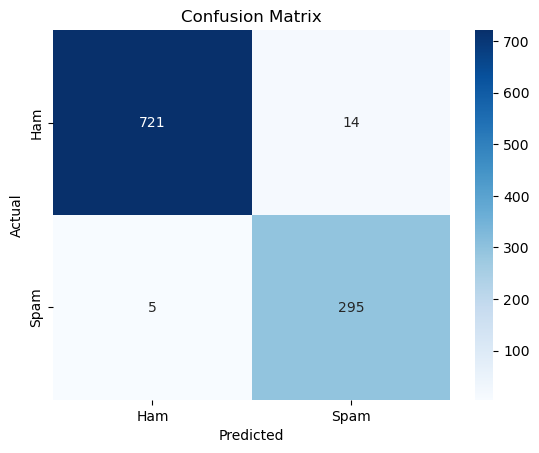

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
import joblib

joblib.dump(svm_model, 'svm_spam_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [11]:

def predict_email_user_input():
    # Ask the user to input the email
    email_text = input("Enter the email content:\n\n")
    
    # Clean the email
    text_clean = email_text.lower()
    text_clean = re.sub(r'\r\n', ' ', text_clean)
    text_clean = re.sub(r'[^a-z0-9@$% ]', ' ', text_clean)
    
    # Vectorize using the trained TF-IDF
    vec = vectorizer.transform([text_clean])
    
    # Predict using the trained SVM
    pred = svm_model.predict(vec)
    
    # Output result
    if pred[0] == 1:
        print("\nThe email is classified as: SPAM 🚨")
    else:
        print("\nThe email is classified as: HAM ✅")

# Call the function
predict_email_user_input()



The email is classified as: SPAM 🚨
